<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#MHW-statistics" data-toc-modified-id="MHW-statistics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>MHW statistics</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plotting</a></span><ul class="toc-item"><li><span><a href="#Selected-subplots" data-toc-modified-id="Selected-subplots-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Selected subplots</a></span><ul class="toc-item"><li><span><a href="#MHWs" data-toc-modified-id="MHWs-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>MHWs</a></span></li></ul></li></ul></li></ul></div>

In [1]:
%matplotlib inline

import sys
sys.path.append("../")  # adds upper level to working directory
# somehow the other way does not work
from utils.orca_utilities import deseason_month,load_orca_EIO,find_common_cmax
from utils.mhw_detection import detect_events
from utils.plot_utils import finished_plot


import matplotlib.pyplot as plt
import cmocean as cmo
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

# Load data

In [3]:
###########################
# Load data 
###########################
#
############## NNI ##############
# load NNI index
k003 = xr.open_dataset('../data/NNI_K003_22S_32S_110E_117W.nc')
k004 = xr.open_dataset('../data/NNI_K004_22S_32S_110E_117W.nc')
k005 = xr.open_dataset('../data/NNI_K005_22S_32S_110E_117W.nc')
#
# create boolean array 
pval = 10    # define threshold
bool_mhw,bool_mcw = detect_events(k003,pval,0,'monthly')
#
#
############## ONI index #########
# load all indices
indices = xr.open_dataset('../data/indices_noaa_psl_May_13_2020.nc')
#
# create bool for oni, i.e. find El Nino and La Nino events
bool_nino = indices['oni'].copy(True)
bool_nino[bool_nino>=0.5] = 1
bool_nino[bool_nino<0.5] = np.nan
bool_nina = indices['oni'].copy(True)
bool_nina[bool_nina>-0.5] = np.nan
bool_nina[bool_nina<=-0.5] = 1
#
#
######## Derive Coastal-Wind-Index (Kataoka 2014) #########
# 108-114E, 22-28S
# wind = xr.open_dataset('/vortex/clidex/data/forcing/JRA55/data/cwi_jra55_kataoka2014.nc')
# wind = wind.drop('lat').drop('lon').drop('height')
# wind = wind.sel(time=slice('1958-01-01','2016-12-31'))
# wind['var34'] = np.squeeze(wind['var34'])
# wind = wind.resample(time="M").mean()
# winda = (wind.groupby('time.month') - wind.groupby('time.month').mean('time'))   # positive from N to S

# surface wind stress model output
# tauy = xr.open_dataset('/vortex/clidex/data/ORCA/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2_processed_EIO/ORCA025.L46.LIM2vp.CFCSF6.JRA.XIOS2-K003.hindcast_1957_2016_TAUY_EIO_grid_V.nc')
# tauya = deseason_month(tauy).where(tauy['sometauy'][0,::]!=0)*(-1)


calculate monthly threshold


# MHW statistics

This should ideally happen in a separate script that can then be called in the notebook if necessary

In [56]:
# create dict with MHW metrics

# # copy to not modify boolean array
# test = bool_mhw.fillna(0)
# # manually separate long event in 2010-2012 (have to exclude one month the way I am doing it now though)
# test[np.where((bool_mhw.time_counter.dt.year==2011) & (bool_mhw.time_counter.dt.month==8))] = 0

# # create dictionary
# mhw = {}
# mhw['ind'] = np.where(test==1)
# mhw['time'] = k003['time_counter'].values[mhw['ind']]
# mhw['temp'] = k003['votemper'].values[mhw['ind'],:]
# mhw['start'] = mhw['time'][np.insert(np.diff(mhw['ind']),0,12)>1]
# mhw['end'] = mhw['time'][np.insert(np.diff(mhw['ind']),-1,10)>1]
# mhw['duration'] = ((mhw['end']-mhw['start']).astype('timedelta64[M]'))+1
# mhw['cwi'] = tauya['sometauy'].sel(lon=slice(108,114),lat=slice(-28,-22)).mean(('lon','lat'))[mhw['ind']]

# # have to add August back into one of the events (will do end of 2011 event)
# # it's the 4th last event 
# mhw['end'][-4] = mhw['end'][-4] + np.timedelta64(31,'D')  # July has 31 days, so need to add 31
# # check that it worked
# print(mhw['end'][-4])

# # save to file
# np.save('../data/mhw_stats_2011_event.npy',[mhw])
mhw = np.load('../data/mhw_stats_2011_event.npy',allow_pickle=True).item()

cwi = np.empty([len(mhw['start'])])

for i in range(len(mhw['start'])):
#     cwi[i] = mhw['cwi'].sel(time_counter=slice(mhw['start'][i],mhw['end'][i])).mean('time_counter')
    cwi[i] = mhw['cwi'].sel(time_counter=slice(mhw['start'][i],mhw['end'][i])).max()

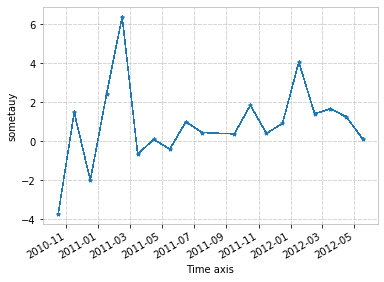

In [57]:
# CWI for 2010/2011 event
(mhw['cwi']*100).sel(time_counter=slice('2010-10-01','2012-09-01')).plot(marker='*')

# Plotting

## Selected subplots


### MHWs

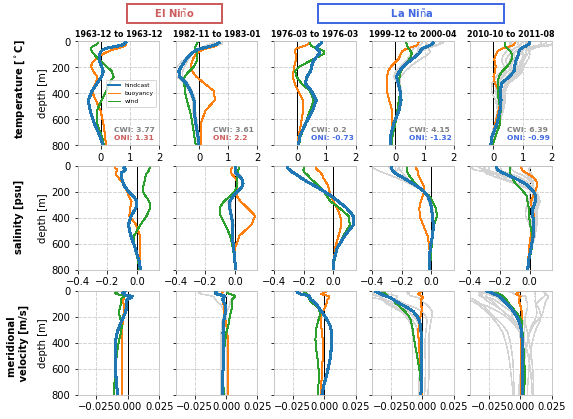

In [58]:
var = 'votemper'
fig,ax = plt.subplots(ncols=5,nrows=3,figsize=(8.5,6.5),sharey=True,constrained_layout=False)
cols = plt.get_cmap('tab10')
fs=8
plt.rcParams.update({'font.size':8})

# if var=='vomecrty': depth = 'depthv'
# else: depth = 'deptht'
    
# Which events to use
indevent = [6,11,9,23,26]

for nn in range(5):
    for rr,var in zip(range(3),['votemper','vosaline','vomecrty']):
        if var=='vomecrty': depth = 'depthv'
        else: depth = 'deptht'
        ind = indevent[nn]
        ax[rr,nn].axvline(0,color='k',linewidth=0.5,linestyle='dashed')
        temp = k003[var].sel(time_counter=slice(mhw['start'][ind],mhw['end'][ind]))
        temp004 = k004[var].sel(time_counter=slice(mhw['start'][ind],mhw['end'][ind]))
        temp005 = k005[var].sel(time_counter=slice(mhw['start'][ind],mhw['end'][ind]))

        for i in range(len(temp.time_counter.values)):
            temp[i,:].plot(y=depth,yincrease=False,ax=ax[rr,nn],color='lightgray',linewidth=0.5)
        temp.mean('time_counter').plot(y=depth,yincrease=False,ax=ax[rr,nn],color=cols(0),label='hindcast',linewidth=2,zorder=20)
        temp004.mean('time_counter').plot(y=depth,yincrease=False,ax=ax[rr,nn],color=cols(1),label='buoyancy',linewidth=1)
        temp005.mean('time_counter').plot(y=depth,yincrease=False,ax=ax[rr,nn],color=cols(2),label='wind',linewidth=1)
        if var=='votemper':ax[rr,nn].set_title(pd.to_datetime(mhw['start'][ind])
                                                .strftime('%Y-%m') + ' to '+
                                                pd.to_datetime(str(mhw['end'][ind]))
                                                .strftime('%Y-%m'),fontsize=fs,fontweight='bold')
        ax[rr,nn].set_ylabel('')
#         ax[rr,nn].set_xlabel('')
        
        # add mean ONI value as text
        if var=='votemper': 
            x=0.45;y=0.05
#           else: x=0.05;y=0.05
            oni_mean = indices['oni'].sel(Month=slice(mhw['start'][ind]-np.timedelta64(17,'D'),
                                                 mhw['end'][ind])).mean('Month').round(2).values
            if oni_mean>=0.5:ax[rr,nn].text(x, y, 'ONI: ' + str(oni_mean), transform=ax[rr,nn].transAxes,size=fs-0.5,
                                            weight='bold',color='indianred')
            elif oni_mean<=-0.5:ax[rr,nn].text(x, y, 'ONI: ' + str(oni_mean), transform=ax[rr,nn].transAxes,size=fs-0.5,
                                               weight='bold',color='royalblue')
            else: ax[rr,nn].text(x, y, 'ONI: ' + str(oni_mean), transform=ax[rr,nn].transAxes,size=8, 
                                 weight='bold',color='gray')
            tni = (indices['tni'].sel(Month=slice(mhw['start'][ind]-np.timedelta64(17,'D'),mhw['end'][ind])).mean('Month')-
                 indices['tni'].mean('Month')).round(2).values
    #         ax[rr,nn].text(0.6, 0.4, 'TNI: ' + str(tni), transform=ax[rr,nn].transAxes,size=8, weight='bold',color='gray')
            ax[rr,nn].text(x, y+0.08, 'CWI: ' + str(round(cwi[ind]*100,2)), transform=ax[rr,nn].transAxes,size=fs-0.5,
                           weight='bold',color='gray')

    
        # set axis labels & ranges
        if nn==0: ax[rr,nn].set_ylabel('depth [m]')
        if rr==4: ax[rr,nn].set_xlabel(var)
        if var=='votemper': ax[rr,nn].set_xlim(-0.8,2);ax[rr,nn].set_xlabel('')
        if var=='vosaline': ax[rr,nn].set_xlim(-0.4,0.15);ax[rr,nn].set_xlabel('')
        if var=='vomecrty': ax[rr,nn].set_xlim(-0.04,0.025);ax[rr,nn].set_xlabel('');
        ax[rr,nn].set_ylim(800,0)
        # raise index but stop loop if out of range
        ind=ind+1
        if ind>=len(mhw['start']):break
            
ax[0,0].legend(fontsize=6,loc='right') 

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)

# row and columns labels
t = plt.text(0.02, 0.68, 'temperature [$^\circ$C]', transform=plt.gcf().transFigure,
                size=10, weight='bold',zorder=10,rotation=90)
t = plt.text(0.02, 0.43, 'salinity [psu]', transform=plt.gcf().transFigure,
                size=10, weight='bold',zorder=10,rotation=90)
t = plt.text(0.01, 0.15, 'meridional \n velocity [m/s]', transform=plt.gcf().transFigure,
                size=10, weight='bold',zorder=10,rotation=90,multialignment='center')

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="indianred", lw=2)
t = plt.text(0.21, 0.93, r'       El Ni$\tilde{\mathrm{n}}$o        ', transform=plt.gcf().transFigure,
                size=10, weight='bold',zorder=10,multialignment='center',color='indianred',bbox=bbox_props)
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="royalblue", lw=2)
t = plt.text(0.67, 0.93, r'                    La Ni$\tilde{\mathrm{n}}$a                    ', transform=plt.gcf().transFigure,
                size=10, weight='bold',zorder=10,ha='center',color='royalblue',bbox=bbox_props)
# for i in np.arange(-5,0): fig.delaxes(ax.flatten()[i])
# finished_plot(fig,'/climodes/data4/sryan/plots_rev/main_figs/subplots_selected_mhw_V2.png')